## Logistic Regression to Predict High or Low Traffic Accident Severity

First pass accuracy was 69.44% and below are original classification and confusion matrix.  Updates are adding Distance, Precipitation and Visibility as binary columns and identifying feature reduction.

In [30]:
# accuracy_score first pass (y_test, y_pred)

0.6944069801888199

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('C:/data/Accidents.csv')

## Feature Engineering and Subsetting

In [3]:
# Reduce traffic Severity from four categories down to two for Logistic Regression
data['Severity01'] = data['Severity'].apply(lambda x: 1 if x >= 3 else 0)
data['SeverityLoHi'] = data['Severity'].apply(lambda x: "High" if x >= 3 else "Low")

In [4]:
# These features with a high percentage of single values made binary
data['DistanceZero'] = data['Distance(mi)'].apply(lambda x: 1 if x == 0 else 0)
data['PrecipitationZero'] = data['Precipitation(in)'].apply(lambda x: 1 if x == 0 else 0)
data['VisibilityTen'] = data['Visibility(mi)'].apply(lambda x: 1 if x == 10 else 0)

In [4]:
# Convert Civil Twilight from Day Night to 0 1
data['DayNight01'] = data['Civil_Twilight'].apply(lambda x: 1 if x == 'Night' else 0)

Text(0.5, 1.0, 'Low vs High Accident Traffic Severity Counts')

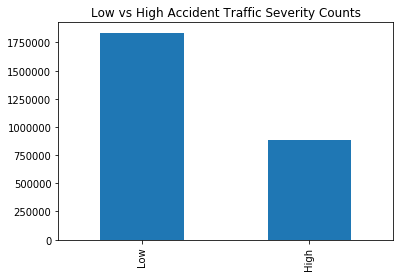

In [18]:
# Twice as many Low Severity Accidents vs. High Severity
data.SeverityLoHi.value_counts().plot(kind='bar')
plt.title('Low vs High Accident Traffic Severity Counts')


In [8]:
subset = data.drop(['Weather_Timestamp', 'Weather_Condition', 'ID', 'Source', 'Severity', 'SeverityLoHi', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Description', 'Wind_Direction', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Zip2', 'Country', 'Timezone', 'Airport_Code', 'Duration', 'Month', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis = 1)

In [9]:
subset = pd.get_dummies(data = subset, columns = ['Weather_Group', 'weekday', 'hour'] )

In [21]:
subset.columns

Index(['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Duration(m)',
       'Severity01', 'DistanceZero', 'PrecipitationZero', 'VisibilityTen',
       'DayNight01', 'Weather_Group_Clear', 'Weather_Group_Cloudy',
       'Weather_Group_Heavy Precip', 'Weather_Group_Light Precip',
       'Weather_Group_Obscured', 'Weather_Group_Windy', 'weekday_Fri',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22'

In [22]:
subset.shape

(2717404, 64)

## Feature Ranking

In [25]:
# In EDA, only correlation over 50% was between Temperature and Wind Chill.  Remove Wind Chill.
old_corr = subset[['Temperature(F)', 'Wind_Chill(F)']]
corr = old_corr.corr(method = 'pearson')
print(corr)

                Temperature(F)  Wind_Chill(F)
Temperature(F)        1.000000       0.833849
Wind_Chill(F)         0.833849       1.000000


In [10]:
subset = subset.drop(['Wind_Chill(F)'], axis = 1)

In [11]:
# Separate X, y
y = subset.Severity01
X = subset.drop(['Severity01'], axis=1)

In [30]:
X.shape

(2717404, 62)

In [12]:
# Run a tree-based estimator

dt = DecisionTreeClassifier(random_state = 7, criterion = 'entropy', max_depth =10)
dt.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7, splitter='best')

In [13]:
# Feature importance rank
fi_col = []
fi = []
for i, column in enumerate(subset.drop(['Severity01'], axis=1)):
    fi_col.append(column)
    fi.append(dt.feature_importances_[i])    # attribute of Decision Tree Classifier

In [15]:
# View Feature importance rank
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature', 'Importance'])
fi_df = fi_df.sort_values('Importance', ascending = False).reset_index()
fi_df[fi_df.Importance > 0]

,index,Feature,Importance
0,20,Duration(m),0.380498
1,18,Traffic_Signal,0.309682
2,0,Distance(mi),0.104732
3,16,Stop,0.032127
4,11,Junction,0.031207
5,33,weekday_Sat,0.029693
6,9,Crossing,0.028131
7,34,weekday_Sun,0.026977
8,24,DayNight01,0.020618
9,3,Pressure(in),0.009415


An interesting ranking.  Seven fields had zero impact on the dependent variable.  Traffic signals, stop signs, intersections and crosswalks are far more indicative of traffic severity than weather.  There are no weather indicators until the 10th - 12th position, unexpectedly lead by Pressure.  One of the created fields, DayNight, made the top ten.  I am surprised to see Heavy Precipitation ranking so low, maybe due to causing slower travel speeds.  

There is also a large spread between weekend days and weekdays.  I can exclude time of day from our predictive model by limiting to the first twelve features in the ranking.

In [16]:
columns_to_keep = fi_df['Feature'][0:12]

## Split, Scale, Logistic Regression Model

In [17]:
# Split X, y kept columns
X = subset[columns_to_keep].values
y = subset['Severity01'].astype(int)

In [18]:
# Create training, test, validate sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=7)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(1956530, 12)
(543481, 12)
(217393, 12)
(1956530,)
(543481,)
(217393,)


In [19]:
steps = [('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state = 7, solver='saga'))]

In [20]:
pipeline = Pipeline(steps)

In [21]:
logreg_scaled = pipeline.fit(X_train, y_train)

In [22]:
# Predict class labels for samples in X
y_pred = logreg_scaled.predict(X_test)

In [23]:
# Probability estimates
pred_proba = logreg_scaled.predict_proba(X_test)

# Evaluate the Linear Regression Model

In [24]:
# Accuracy on training
print("The training accuracy is ", logreg_scaled.score(X_train, y_train))

# Accuracy on testing
print("The testing accuracy is ", logreg_scaled.score(X_test, y_test))

The training accuracy is  0.6912707701900814
The testing accuracy is  0.6924124302413516


Narrowing the feature selection has a lower accuracy score then the original run.  I will re-evaluate with all the features with an Important score above 0.

In [25]:
more_columns_to_keep = fi_df['Feature'][0:55]
X2 = subset[more_columns_to_keep].values
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=7)
X2_train, X2_valid, y_train, y_valid = train_test_split(X2_train, y_train, test_size = 0.1, random_state=7)
steps2 = [('scaler2', StandardScaler()), ('logreg2', LogisticRegression(random_state = 7))]
pipeline2 = Pipeline(steps2)
logreg2_scaled = pipeline2.fit(X2_train, y_train)
print("The 2nd testing accuracy is ", logreg2_scaled.score(X2_test, y_test))

The 2nd testing accuracy is  0.6938862628132354


The original logistic regression, the details of which I did not keep for reproduction, had the highest accuracy score of 69.44.  It used all of the fields from EDA and did not include the new binary columns for Distance, Precipitation and Visibility.  Selecting the top 12 features by importance of a decision tree classifier yielded lower accuracy of 69.24.  The third pass using all features greater than zero importance yielded accuracy of 69.39.

In [68]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(pipeline2, X2, y, cv=5)

In [69]:
# CV Scores
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.68999284 0.69549809 0.69052276 0.68822093 0.69239346]
Average 5-Fold CV Score: 0.6913256185196776


I don't believe there is overfitting due to the low variation in cross-validation.

In [74]:
# Classification report
y_pred2 = logreg2_scaled.predict(X2_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81    367866
           1       0.58      0.19      0.28    175615

    accuracy                           0.69    543481
   macro avg       0.64      0.56      0.54    543481
weighted avg       0.67      0.69      0.64    543481



The high recall for 0 is an indication most low-severity traffic accidents were predicted correctly.

In [78]:
print(confusion_matrix(y_test, y_pred2))

[[344028  23838]
 [142529  33086]]


In [79]:
# confusion matrix percentages
cm = confusion_matrix(y_test, y_pred2)
cmpct = cm / cm.sum(axis=1).reshape(-1,1)
print(cmpct)

[[0.93519923 0.06480077]
 [0.81159924 0.18840076]]


False positives in the lower left corner appear to drive the inaccuracy.  They are actual high severity traffic (1) but predicted incorrectly as low severity (0).  This is a substantial problem as motorists would be led erroneously into waiting in extensive traffic delays.  High severity accident traffic was only correctly predicted 18.8% of the time.  

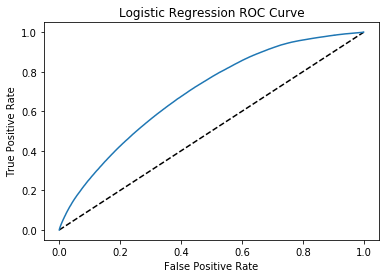

In [72]:
# Plotting the ROC curve
y_pred_prob = pipeline2.predict_proba(X2_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title('Logistic Regression ROC Curve')
plt.show()

In [84]:
roc_auc_score(y_test, y_pred_prob)

0.694535048057978

This classifier has a poor discriminative ability.

In [33]:
# Hyperparameter C
from sklearn.linear_model import LogisticRegressionCV
C_List = np.geomspace(1e-5, 1e5, num=20)
kf = KFold(n_splits = 3, random_state = 0, shuffle = True)
Logreg3 = LogisticRegressionCV(cv=kf, random_state=15, Cs = C_List)
Logreg3.fit(X2_train, y_train)
print("The CA is ", Logreg3.score(X2_test, y_test))
pred_proba_t = Logreg3.predict_proba(X2_test)
log_loss3 = log_loss(y_test, pred_proba_t)
print("The Logistic Loss is ", log_loss3)
print("The optimal C parameter is ", Logreg3.C_)


C:\Users\ggibs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ggibs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

C:\Users\ggibs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\ggibs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The CA is  0.6926718689337805
The Logistic Loss is  0.576518112422818
The optimal C parameter is  [8858.6679041]


## Comparison to Random Forest

In [5]:
rfset = data.drop(['Weather_Timestamp', 'Weather_Condition', 'ID', 'Source', 'Severity', 'SeverityLoHi', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Description', 'Wind_Direction', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Zip2', 'Country', 'Timezone', 'Airport_Code', 'Duration', 'Month', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis = 1)


In [6]:
# Run a plain RF on recreated original X, y
from sklearn.ensemble import RandomForestClassifier

# Due to robustness of Random Forest classifiers, the following pre-processing for Logistic Regression was not made:
    # Dropping high correlation feature Wind Chill
    # Creating binary dummy features for very low variance 'Distance', 'Precipitation', 'Visibility'

rfset = data.drop(['Weather_Timestamp', 'Weather_Condition', 'ID', 'Source', 'Severity', 'SeverityLoHi', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Description', 'Wind_Direction', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Zip2', 'Country', 'Timezone', 'Airport_Code', 'Duration', 'Month', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'PrecipitationZero', 'DistanceZero', 'VisibilityTen'], axis = 1)
rfset = pd.get_dummies(data = rfset, columns = ['Weather_Group', 'weekday', 'hour'] )

# Separate X, y, train, test, validate
yrf = rfset.Severity01
Xrf = rfset.drop(['Severity01'], axis=1)

Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split(Xrf, yrf, test_size = 0.2, random_state=7, stratify=y)
Xrf_train, Xrf_valid, yrf_train, yrf_valid = train_test_split(Xrf_train, yrf_train, test_size = 0.1, random_state=7, stratify=y)

rf = RandomForestClassifier()
rf.fit(Xrf_train, yrf_train)

yrf_pred= rf.predict(Xrf_test) 
print("RF Accuracy: ", rf.score(Xrf_test, yrf_test))


RF Accuracy:  0.7395180328291145
[[325128  42738]
 [ 98829  76786]]


In [7]:
# Confusion Matrix
pd.crosstab(yrf_test, yrf_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,325128,42738
1,98829,76786


In [15]:
# Confusion Matrix percentages
cm = confusion_matrix(yrf_test, yrf_pred)
cmpct = np.round(cm / cm.sum(axis=1).reshape(-1,1), 2)
print(cmpct)

[[0.88 0.12]
 [0.56 0.44]]


Significant improvement over Logistic Regression identifying High Severity with True Negative quadrant more than doubling.  A 30% reduction of False Positives, which are a concern, predicting incorrectly low severity traffic when in actuality it is severe.

In [6]:
# Are high severity incidents under-represented?  Equalize count with low severity.
high_count = rfset.Severity01[rfset.Severity01 == 1].count()
equaldf = rfset[rfset.Severity01 == 1]
lows = rfset[rfset.Severity01 == 0].sample(n=high_count, random_state=7)
equaldf = equaldf.append(lows)
equaldf.Severity01.value_counts()

1    880347
0    880347
Name: Severity01, dtype: int64

In [37]:
# Check improved Confusion Matrix with equal category counts
yrfe = equaldf.Severity01
Xrfe = equaldf.drop(['Severity01'], axis=1)

Xrfe_train, Xrfe_test, yrfe_train, yrfe_test = train_test_split(Xrfe, yrfe, test_size = 0.2, random_state=7)
Xrfe_train, Xrfe_valid, yrfe_train, yrfe_valid = train_test_split(Xrfe_train, yrfe_train, test_size = 0.1, random_state=7)

rfe = RandomForestClassifier()
rfe.fit(Xrfe_train, yrfe_train)

yrfe_pred= rfe.predict(Xrfe_test) 
print("RF Accuracy: ", rfe.score(Xrfe_test, yrfe_test))

pd.crosstab(yrfe_test, yrfe_pred, rownames=['Actual Result'], colnames=['Predicted Result'])
cme = confusion_matrix(yrfe_test, yrfe_pred)
cmpcte = np.round(cme / cme.sum(axis=1).reshape(-1,1), 2)
print(cmpcte)

RF Accuracy:  0.7081237806661574
[[0.68 0.32]
 [0.26 0.74]]


I am very pleased to see the False Positives cut by 50% further, and a higher rate of identifying High Severity Accident Traffic than Low.  As noted previously, the model needs to minimize false positives, which is High Severity incorrectly identified as Low Severity.

If a motorist is told an accident will cause High Severity traffic, in error, they will take an alternate route, or be pleasantly surprised when actual traffic is less than expected, and thus a much less problematic prediction than the opposite.

In [38]:
# Classification report
print(classification_report(yrfe_test, yrfe_pred))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70    175525
           1       0.70      0.74      0.72    176614

    accuracy                           0.71    352139
   macro avg       0.71      0.71      0.71    352139
weighted avg       0.71      0.71      0.71    352139



The weighted average F1 sore increased from 64 to 71.  

In [39]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(rfe, Xrfe, yrfe, cv=5)

In [40]:
# CV Scores
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.58522913 0.62667867 0.55601907 0.62823203 0.60886925]
Average 5-Fold CV Score: 0.6010056306567861


Cross-validation scores are consistent, avoiding over-fitting.

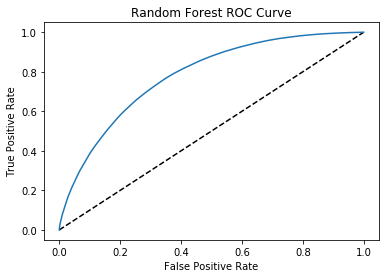

In [41]:
# Plotting the ROC curve
yrfe_pred_prob = rfe.predict_proba(Xrfe_test)[:, 1]
fpr, tpr, thresholds = roc_curve(yrfe_test, yrfe_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title('Random Forest ROC Curve')
plt.show()

In [42]:
print("AUC: ", roc_auc_score(yrfe_test, yrfe_pred_prob))

AUC:  0.7794993341545084


Area under curve improved from 69.5 to 77.9

In [43]:
feature_importances = pd.DataFrame(rfe.feature_importances_,
                                   index = Xrfe_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
pd.set_option('display.max_rows', 65)
display(feature_importances)
pd.reset_option('display.max_rows')

,importance
Duration(m),0.141785
Wind_Chill(F),0.109764
Pressure(in),0.103189
Temperature(F),0.096587
Humidity(%),0.096222
Wind_Speed(mph),0.079236
Distance(mi),0.054535
Precipitation(in),0.051111
Traffic_Signal,0.045925
Visibility(mi),0.023941


The Random Forest relied on Wind Chill, which was dropped for the Logistic Regression due to high correlation with Temperature.  Pressure is important again, this weather metric is high for nice weather and low for cloudy, raining, or snowing. Traffic Signal and Crosswalk are again in the top 12 features, followed by all of the days close together.

Is there more improvement ignoring days, hours, weather groups and everything lower?

In [8]:
# Rerun with most important features
from sklearn.ensemble import RandomForestClassifier
yrfe = equaldf.Severity01
Xrfe11 = equaldf[['Duration(m)', 'Wind_Chill(F)', 'Pressure(in)', 'Temperature(F)', 'Humidity(%)', 'Wind_Speed(mph)', 'Distance(mi)', 'Precipitation(in)', 'Traffic_Signal', 'Visibility(mi)', 'Crossing']]

Xrfe11_train, Xrfe11_test, yrfe_train, yrfe_test = train_test_split(Xrfe11, yrfe, test_size = 0.2, random_state=7)
Xrfe11_train, Xrfe11_valid, yrfe_train, yrfe_valid = train_test_split(Xrfe11_train, yrfe_train, test_size = 0.1, random_state=7)

rfe11 = RandomForestClassifier()
rfe11.fit(Xrfe11_train, yrfe_train)

yrfe_pred= rfe11.predict(Xrfe11_test) 
print("RF Accuracy: ", rfe11.score(Xrfe11_test, yrfe_test))

pd.crosstab(yrfe_test, yrfe_pred, rownames=['Actual Result'], colnames=['Predicted Result'])
cme11 = confusion_matrix(yrfe_test, yrfe_pred)
cmpcte11 = np.round(cme11 / cme11.sum(axis=1).reshape(-1,1), 2)
print(cmpcte11)

RF Accuracy:  0.686714621214918
[[0.64 0.36]
 [0.27 0.73]]


Slightly underperforming what we had previously with all the fields.  False Positives only went up 1 point, but reduced from 60 fields to 11 to lesson computational load for hyperparameter tuning.

## Hyperparameter Tuning

In [9]:
# Random Hyperparameter Grid
from sklearn.ensemble import RandomForestClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
#               'bootstrap': bootstrap}

# Random Search Training

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 50 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=7, n_jobs = -1)
# Fit the random search model
rfc_random.fit(Xrfe11_valid, yrfe_valid)

rfc_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.1min
C:\Users\ggibs\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 83.3min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20}

In [12]:
rf_tune = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 4, max_depth = 20)
rf_tune.fit(Xrfe11_train, yrfe_train)

ytune_pred= rf_tune.predict(Xrfe11_test) 
print("RF Accuracy: ", rf_tune.score(Xrfe11_test, yrfe_test))

pd.crosstab(yrfe_test, ytune_pred, rownames=['Actual Result'], colnames=['Predicted Result'])
cm_tune = confusion_matrix(yrfe_test, ytune_pred)
cmpct_tune = np.round(cm_tune / cm_tune.sum(axis=1).reshape(-1,1), 2)
print(cmpct_tune)

RF Accuracy:  0.6810577641215543
[[0.63 0.37]
 [0.27 0.73]]


Hyperparameter tuning on the reduced feature count was not an improvement.  True Positives declined 1 point and accuracy fell half a percent.